## Importing Necessary Libraries


In [676]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import OrdinalEncoder,LabelEncoder





import re
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tag import pos_tag
from wordcloud import WordCloud,STOPWORDS


## Reading the Data


In [677]:
df = pd.read_excel("E:\Downloads\data_airline_reviews.xlsx")
df.head()

,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,âœ… Trip Verified | London to Izmir via Istanb...,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4.0,5.0,4.0,4.0,2.0,4.0,yes
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,âœ… Trip Verified | Istanbul to Bucharest. We ...,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4.0,1.0,1.0,1.0,1.0,1.0,no
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Information about the dataset.
    The first dataset is scraped from Skytrax (https://www.airlinequality.com), an international air transport rating organization based in the UK, whose mission is to improve the customer experience for airlines and airports across the world. The dataset consists of individual reviews left by verified customers of most of the major airlines across the world

### Problem Statement:
        
       To improve customer satisfaction, the airline industry needs to effectively analyze and understand customer feedback. By leveraging a dataset of individual reviews from Skytrax, we aim to develop a classification model that can automatically categorize customer reviews based on sentiment and other relevant factors. This model will enable airlines to quickly identify areas of improvement, prioritize customer-centric initiatives, and ultimately enhance the overall travel experience.

In [678]:
print('No. of customer reviews in the dataset:',df.shape[0])


No. of customer reviews in the dataset: 131895


In [679]:
print('No. of columns:',df.shape[1])
print(df.columns.to_list())

No. of columns: 17
['airline', 'overall', 'author', 'review_date', 'customer_review', 'aircraft', 'traveller_type', 'cabin', 'route', 'date_flown', 'seat_comfort', 'cabin_service', 'food_bev', 'entertainment', 'ground_service', 'value_for_money', 'recommended']


In [680]:
#Information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131895 entries, 0 to 131894
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          65947 non-null  object 
 1   overall          64017 non-null  float64
 2   author           65947 non-null  object 
 3   review_date      65947 non-null  object 
 4   customer_review  65947 non-null  object 
 5   aircraft         19718 non-null  object 
 6   traveller_type   39755 non-null  object 
 7   cabin            63303 non-null  object 
 8   route            39726 non-null  object 
 9   date_flown       39633 non-null  object 
 10  seat_comfort     60681 non-null  float64
 11  cabin_service    60715 non-null  float64
 12  food_bev         52608 non-null  float64
 13  entertainment    44193 non-null  float64
 14  ground_service   39358 non-null  float64
 15  value_for_money  63975 non-null  float64
 16  recommended      64440 non-null  object 
dtypes: float64

## Preliminary fixes of the input data

In [681]:
df['customer_review'][1]

'âœ… Trip Verified | London to Izmir via Istanbul. First time Iâ€™d flown TK. I found them very good in the air, cabin crew, planes, food, all very nice. Not so great on the ground, ground staff, call centre, computer systems. My flight from LHR was delayed so I missed the connection in Istanbul. Most ground staff donâ€™t speak English, and I was given contradictory instructions from those that could speak a little English. I eventually got on a flight to Izmir three hours later, but it wasnâ€™t an easy process, made worse by the vast distances one has to walk between gates in the cavernous new airport. Also, Iâ€™d phoned a TK call centre (based in Ukraine) to pay an extra Â£40 or so each way for extra leg room seats. However, as the departure times kept changing, my seats kept changing, and for the return leg to London from Istanbul I was not given an extra leg room seat. Luckily there was a spare exit row seat and the cabin crew sorted me out. Overall, I think their cabin crew and pl

In [682]:
df[['customer_review','route']]

,customer_review,route
0,NaN,NaN
1,âœ… Trip Verified | London to Izmir via Istanb...,London to Izmir via Istanbul
2,NaN,NaN
3,âœ… Trip Verified | Istanbul to Bucharest. We ...,Istanbul to Bucharest
4,NaN,NaN
...,...,...
131890,Kiev - London (Gatwick) in business class (in ...,NaN
131891,NaN,NaN
131892,Several flights - KBP to AMS (3 times one way)...,NaN
131893,NaN,NaN


* In customer review column starts with a special character and route information. We can strip this information away from the customer review column as it does not add any additional value. We are removing only part till Trip Verified | and route will be treated later while pre-processing the customer_review column.

In [683]:
def text_cleaning(review):
    if isinstance(review,str):
        split_review = review.split('|')    #spliting data using special character |
        if len(split_review)>1:
            return split_review[1].strip()
        else:
            return split_review[0].strip()
    else:
        return np.nan
df['customer_review'] = df['customer_review'].apply(text_cleaning)

In [684]:
df['customer_review'][1]

'London to Izmir via Istanbul. First time Iâ€™d flown TK. I found them very good in the air, cabin crew, planes, food, all very nice. Not so great on the ground, ground staff, call centre, computer systems. My flight from LHR was delayed so I missed the connection in Istanbul. Most ground staff donâ€™t speak English, and I was given contradictory instructions from those that could speak a little English. I eventually got on a flight to Izmir three hours later, but it wasnâ€™t an easy process, made worse by the vast distances one has to walk between gates in the cavernous new airport. Also, Iâ€™d phoned a TK call centre (based in Ukraine) to pay an extra Â£40 or so each way for extra leg room seats. However, as the departure times kept changing, my seats kept changing, and for the return leg to London from Istanbul I was not given an extra leg room seat. Luckily there was a spare exit row seat and the cabin crew sorted me out. Overall, I think their cabin crew and planes are very good, 

## Removing unwanted columns and changing column names

In [685]:
df['author'].nunique()

44069

In [686]:
# Author field is of no use so we are droping it.
df.drop(columns='author',inplace=True)

In [687]:
#Renaming column names 
df.rename(columns={'overall':'overall_review','customer_review':'review_text'},inplace=True)

## Feature Engineering


### 1. Handling route column and converting into origin,destination,layover

In [688]:
def convert_route_origin(i):
    if isinstance(i,str):
        i = i.lower()
        route_list = i.split()
        if route_list[0]=='toronto':
            return route_list[0]
        else:
            
            route_list = i.split('to')
            if len(route_list)==1:
                route_list = ' '.join(route_list)
                route_list = i.split('and')
                if len(route_list)==1:
                    route_list = ' '.join(route_list)
                    route_list = route_list.split('-')
                    if len(route_list)==1:
                        route_list = ' '.join(route_list)
                        route_list = route_list.split('yo')
                        if len(route_list)==1:
                            route_list = ' '.join(route_list)
                            route_list = route_list.split('via')
                            if len(route_list)==1:
                                return route_list[0]
                            return route_list[0].strip()
                        return route_list[0].strip()

                    return route_list[0]
                return route_list[0]
        return route_list[0].strip()
    else:
        return np.nan

In [689]:
def convert_route_destination(i):
    if isinstance(i,str):
        i = i.lower()
        route_list = i.split('to')
        if len(route_list)==1:
            route_list = ' '.join(route_list)
            route_list = route_list.split('-')
            if len(route_list)==1:
                route_list = ' '.join(route_list)
                route_list = route_list.split('and')
                
                if len(route_list)==1:
                    route_list = ' '.join(route_list)
                    route_list = route_list.split('yo')
                    if len(route_list)==1:
                        
                        route_list = ' '.join(route_list)
                        route_list = route_list.split('via')
                        return 'Missing'
                    route_list = ' '.join(route_list)
                    route_list = route_list.split()
                    if len(route_list)==1:
                        return 'Missing'
                    if len(route_list)==3:
                        return ' '.join(route_list[1:])
                    elif len(route_list)<3:
                        return route_list[1]
                    
                    
                return route_list[-1].strip()
            return route_list[1].strip()
        
        
        route_list = ' '.join(route_list)
        route_list = route_list.split()
        #route_list = route_list.split('via')
        #route_list = ' '.join(route_list)
        #route_list = route_list.split()

        return route_list[1].strip()
            
            
    else:
        return np.nan


In [690]:
def convert_route_layover(i):
    if isinstance(i,str):
        i = i.lower()
        route_list = i.split('to')[-1]
        route_list = route_list.split('via')
        if len(route_list)==1:
            route_list = ' '.join(route_list)
            route_list = route_list.split('-')
            if len(route_list)==1:
                route_list = ' '.join(route_list)
                route_list = route_list.split('and')[-1]
                route_list = route_list.split('via')
                if len(route_list)==1:
                    route_list = ' '.join(route_list)
                    route_list = route_list.split()
                    if len(route_list)>=3:
                        return 'No Layover'
                    return 'No Layover'
                return route_list[-1]
            return route_list[-1]
        
            
        return route_list[-1]

    else:
        return np.nan

In [691]:
df['Origin'] = df['route'].apply(convert_route_origin)
df['Destination'] = df['route'].apply(convert_route_destination)
df['Layover'] = df['route'].apply(convert_route_layover)

In [692]:
df[df['Destination']=='n'][['Origin','Destination','Layover']]
#Fixing this issue

,Origin,Destination,Layover
7,washing,n,No Layover
29,hous,n,istanbul
175,bos,n,istanbul
215,washing,n,istanbul
291,bos,n,istanbul
...,...,...,...
131182,bos,n,No Layover
131196,bos,n,No Layover
131202,bos,n,No Layover
131204,bos,n,kef


In [693]:
index = df[df['Destination']=='n'].index

In [694]:
def convert_origin(i):
    if isinstance(i,str):
        i = i.lower()
        route_list = i.split()
        return route_list[0]
    else:
        return np.nan
def convert_destination(i):
    if isinstance(i,str):
        i = i.lower()
        route_list = i.split('to')
        if len(route_list)<=2:
            return 'Missing'
        elif len(route_list)==3:
            route_list = route_list[2]
            route_list = route_list.split()
            if route_list==[]:
                return 'Missing'
            return route_list[0] 
            
    else:
        return np.nan

df.loc[index,'Origin']=df['route'].apply(convert_origin)

df.loc[index,'Destination']=df['route'].apply(convert_destination)

In [695]:
df[['Origin','Destination','Layover']]

,Origin,Destination,Layover
0,NaN,NaN,NaN
1,london,izmir,istanbul
2,NaN,NaN,NaN
3,istanbul,bucharest,No Layover
4,NaN,NaN,NaN
...,...,...,...
131890,NaN,NaN,NaN
131891,NaN,NaN,NaN
131892,NaN,NaN,NaN
131893,NaN,NaN,NaN


In [696]:
def layover(x):
    if isinstance(x,str):
        if x=='No Layover':
            return False
        else:
            return True
    else:
        return np.nan
    
df['has_layover'] = df['Layover'].apply(layover)

In [697]:
df['has_layover'].value_counts()

has_layover
False    27229
True     12497
Name: count, dtype: int64

* The columns 'route', 'origin', 'destination' and 'layover' are ambiguous in the sense that these columns contain a mix of airport city, airport name and airport codes. So we need to remove these columns.

In [698]:
df.drop(columns=['Origin','Destination','Layover'],inplace=True)


### Handling Date columns - review_date,date_flown
* Review_Date
* Review_Month
* Review_Year
* date_flown_day
* date_flown_month
* date_flown_year

In [699]:
def convert_to_date(i):
    if isinstance(i,str):
        return i.split()[0]
    else:
        return np.nan
        
def convert_to_month(i):
    if isinstance(i,str):
        return i.split()[1]
    else:
        return np.nan

def convert_to_year(i):
    if isinstance(i,str):
        return i.split()[2]
    else:
        return np.nan
        

In [700]:
df['Review_Date'] = df['review_date'].apply(convert_to_date)
df['Review_Month'] = df['review_date'].apply(convert_to_month)
df['Review_Year'] = df['review_date'].apply(convert_to_year)

In [701]:
df['Review_Date'].value_counts().index

Index(['28th', '6th', '4th', '20th', '18th', '22nd', '1st', '17th', '10th',
       '14th', '19th', '11th', '5th', '3rd', '13th', '8th', '12th', '29th',
       '25th', '23rd', '21st', '24th', '16th', '9th', '26th', '27th', '2nd',
       '15th', '7th', '30th', '31st'],
      dtype='object', name='Review_Date')

In [702]:
df['Review_Date'] = df['Review_Date'].str.extract('(\d+)')

In [703]:
df['Review_Date'].value_counts().index

Index(['28', '6', '4', '20', '18', '22', '1', '17', '10', '14', '19', '11',
       '5', '3', '13', '8', '12', '29', '25', '23', '21', '24', '16', '9',
       '26', '27', '2', '15', '7', '30', '31'],
      dtype='object', name='Review_Date')

In [704]:
df['Review_Month'].value_counts().index

Index(['January', 'July', 'August', 'October', 'September', 'April', 'March',
       'May', 'June', 'December', 'November', 'February'],
      dtype='object', name='Review_Month')

In [705]:
df['Review_Year'].value_counts().index

Index(['2015', '2018', '2014', '2016', '2017', '2013', '2019', '2012', '2011',
       '2010', '2009', '2006', '2008', '2007', '2005', '2004', '2003', '2002'],
      dtype='object', name='Review_Year')

In [706]:
date=df['date_flown'][df['date_flown'].apply(lambda x: '00:00:00' in str(x))]
df['date_flown'][df['date_flown'].apply(lambda x: '00:00:00' in str(x))]=date.astype(str).str.replace('00:00:00','')

In [707]:
#Removing extra spaces
df['date_flown'] = df['date_flown'].apply(lambda x: x.strip() if isinstance(x,str) else np.nan)

In [708]:
def date_flown(x):
    if isinstance(x,str):
        x = x.split('-')
        if len(x)>=2:
            return x[-1]
        if len(x)==1:
            x = x[0]
            x = x.split(' ')
            if len(x)==2:
                return 'None'
            if len(x)==3:
                return x[-1]
    else:
         return np.nan
    
    
    
def month_flown(x):
    if isinstance(x,str):
        x = x.split('-')
        if len(x)>=2:
            return x[1]
        if len(x)==1:
            x = x[0]
            x = x.split(' ')
        if len(x)==2:
            return x[0]
    else:
         return np.nan
    
        
def year_flown(x):
    if isinstance(x,str):
        x = x.split('-')
        if len(x)>=2:
            return x[0]
        if len(x)==1:
            x = x[0]
            x = x.split(' ')
            if len(x)==2:
                return x[1]


In [709]:
df['date_flown_day']=df['date_flown'].apply(date_flown)
df['date_flown_month']=df['date_flown'].apply(month_flown)
df['date_flown_year']=df['date_flown'].apply(year_flown)


In [710]:
df['date_flown_day'].value_counts()

date_flown_day
None    36855
01       2778
Name: count, dtype: int64

* date_flown_day is of no use there is only one category so we can drop it.

In [711]:
del df['date_flown_day']

In [712]:
df['date_flown_month'].value_counts()
#Need to convert 5 to May

date_flown_month
July         3797
August       3745
December     3640
June         3557
January      3476
September    3350
October      3313
November     3111
March        3104
April        3060
05           2778
February     2702
Name: count, dtype: int64

In [713]:
df['date_flown_month'] = df['date_flown_month'].replace({'05': 'May'})

In [714]:
df['date_flown_year'].value_counts()

date_flown_year
2018    10406
2016     8964
2017     8909
2015     7614
2019     3626
2014      112
2013        2
Name: count, dtype: int64

In [715]:
#Droping route,review_date and date_flown columns because we have converted them
df.drop(columns=['review_date','date_flown'],inplace=True)

In [716]:
# We will classify the overall review into one of the 3 categories: Positive, Neutral and Negative
def overall_review_score(i):
    """
    Return:
    - 'pos' if the review score is positive (>=7),
    - 'neu' if the review score is neutral (5 or 6),
    - 'neg' if the review score is negative (<=4).
    """
    if isinstance(i,float):
        if (i <= 4):
            return 'neg'
        elif(i> 4 and i <= 6):
            return 'neu'
        elif(i> 6 and i <= 10):
            return 'pos'
        else:
            return np.nan
        
    else:
        return np.nan
    

In [717]:
df['pos_neu_neg_review_score'] = df['overall_review'].apply(overall_review_score)

In [718]:
df['pos_neu_neg_review_score'].value_counts()

pos_neu_neg_review_score
neg    30016
pos    28179
neu     5822
Name: count, dtype: int64

## Handling NaNs


### Percentage of null values in each column

In [719]:
null_counts = df.isnull().sum().sort_values(ascending=False)/len(df) * 100
null_counts

aircraft                    85.050229
ground_service              70.159597
date_flown_year             69.951097
date_flown_month            69.951097
has_layover                 69.880587
route                       69.880587
traveller_type              69.858600
entertainment               66.493802
food_bev                    60.113727
seat_comfort                53.992949
cabin_service               53.967171
cabin                       52.005004
value_for_money             51.495508
pos_neu_neg_review_score    51.463664
overall_review              51.463664
recommended                 51.142955
Review_Date                 50.000379
Review_Month                50.000379
Review_Year                 50.000379
review_text                 50.000379
airline                     50.000379
dtype: float64

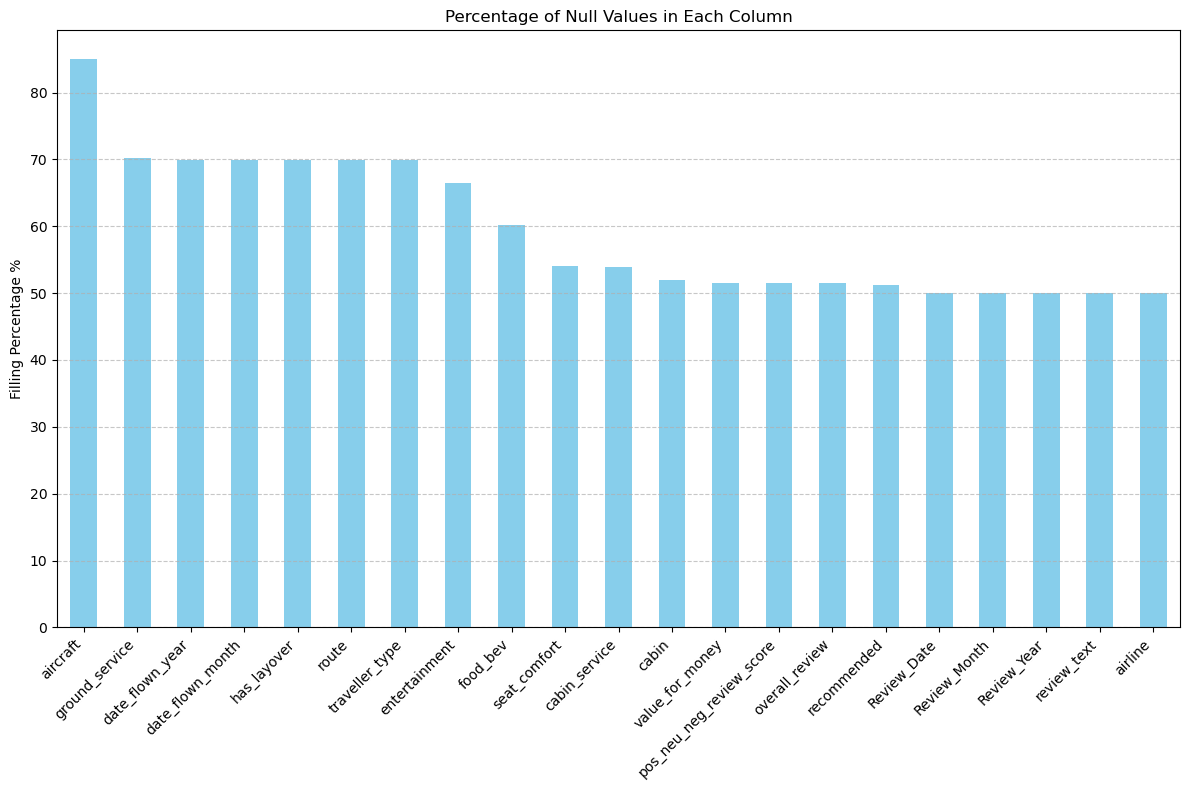

In [720]:
null_counts = df.isnull().sum().sort_values(ascending=False)/len(df) * 100

# Customize the plot
plt.figure(figsize=(12, 8))
ax = null_counts.plot(kind='bar', color='skyblue')
ax.set_ylabel('Filling Percentage %')
ax.set_title('Percentage of Null Values in Each Column')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

* Dropping aircraft column because it consists of 85% of Null data

In [721]:
del df['aircraft']

### Duplicates in the data

In [722]:
df[df.duplicated()].shape[0]/len(df) * 100

53.61158497289511

In [723]:
df.shape

(131895, 20)

In [724]:
#Dropping Duplicates and checking null values
df.drop_duplicates(ignore_index=True,inplace=True)


In [725]:
no_of_rows=df.shape[0]
print('No. of rows after removing duplicates:', no_of_rows) #After dropping Duplicates

No. of rows after removing duplicates: 61184


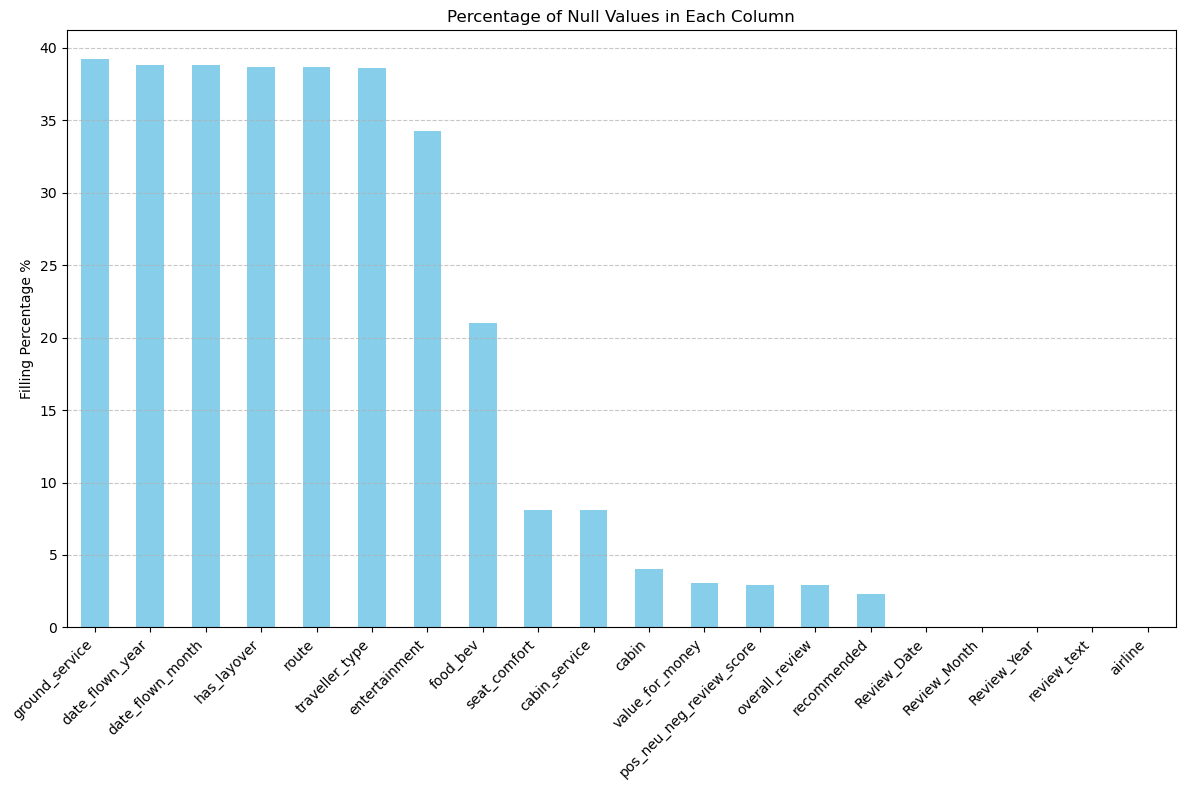

In [726]:
null_counts = df.isnull().sum().sort_values(ascending=False)/len(df) * 100

# Customize the plot
plt.figure(figsize=(12, 8))
ax = null_counts.plot(kind='bar', color='skyblue')
ax.set_ylabel('Filling Percentage %')
ax.set_title('Percentage of Null Values in Each Column')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

* As you can see percentage of null values has dropped after droping duplicate there might be 50% duplicates rows.  

In [727]:
df_without_na = df.dropna(axis=0,how='any',ignore_index=True).copy()

In [728]:
print('No. of rows after removing duplicates and Nans',df_without_na.shape[0])

No. of rows after removing duplicates and Nans 22819


In [729]:
df_without_na.shape[0]/no_of_rows * 100

37.29569822175732

**We are down to 37% of the original data, because of the removal of the NaN values and duplicates, but it is okay for us to train the model on clean data rather than NaN-filled messy data!**

In [730]:
df_final = df_without_na.copy()

In [731]:
final_columns = list(df_final.columns)
print(final_columns)

['airline', 'overall_review', 'review_text', 'traveller_type', 'cabin', 'route', 'seat_comfort', 'cabin_service', 'food_bev', 'entertainment', 'ground_service', 'value_for_money', 'recommended', 'has_layover', 'Review_Date', 'Review_Month', 'Review_Year', 'date_flown_month', 'date_flown_year', 'pos_neu_neg_review_score']


## Unique value analysis for different categorical features.

In [732]:
bool_features = ['recommended',
              'has_layover']
cat_features = ['airline',
             'traveller_type',
             'cabin','review_text',
             'pos_neu_neg_review_score']
num_features = [feat for feat in final_columns if feat not in bool_features and feat not in cat_features]

In [733]:
print(f"Boolean features: \n{bool_features}\n")
print(f"Categorical features: \n{cat_features}\n")
print(f"Numerical features:\n{num_features}\n")

Boolean features: 
['recommended', 'has_layover']

Categorical features: 
['airline', 'traveller_type', 'cabin', 'review_text', 'pos_neu_neg_review_score']

Numerical features:
['overall_review', 'route', 'seat_comfort', 'cabin_service', 'food_bev', 'entertainment', 'ground_service', 'value_for_money', 'Review_Date', 'Review_Month', 'Review_Year', 'date_flown_month', 'date_flown_year']



In [734]:
for column in df_final.columns:
    print('Column:',column)
    print('No. of unique values:',df_final[column].nunique())
    if column!='review_text':
        print(df_final[column].unique())
        print('\n')

Column: airline
No. of unique values: 81
['Turkish Airlines' 'Qatar Airways' 'Emirates' 'Lufthansa'
 'KLM Royal Dutch Airlines' 'Virgin America' 'American Airlines'
 'Delta Air Lines' 'Southwest Airlines' 'United Airlines'
 'Jetblue Airways' 'Aegean Airlines' 'Aeroflot Russian Airlines'
 'Aeromexico' 'Air Canada' 'Air New Zealand' 'Alitalia' 'AirAsia'
 'Asiana Airlines' 'Avianca' 'Austrian Airlines' 'British Airways'
 'Brussels Airlines' 'China Eastern Airlines' 'China Southern Airlines'
 'Copa Airlines' 'Ethiopian Airlines' 'Egyptair' 'Finnair' 'Iberia'
 'ANA All Nippon Airways' 'easyJet' 'Korean Air' 'LATAM Airlines'
 'LOT Polish Airlines' 'Qantas Airways' 'Air France' 'Etihad Airways'
 'Pegasus Airlines' 'Royal Jordanian Airlines' 'Ryanair'
 'South African Airways' 'Saudi Arabian Airlines' 'TAP Portugal'
 'Eurowings' 'EVA Air' 'Royal Air Maroc' 'Singapore Airlines'
 'SAS Scandinavian' 'Swiss Intl Air Lines' 'Thai Airways' 'Air India'
 'Air Europa' 'Air Canada rouge' 'airBaltic' 'Air

In [735]:
for column in df_final.columns:
    print('Column:',column)
    print('No. of unique values:',df_final[column].nunique())
    if column!='review_text':
        print(df_final[column].value_counts())
        print('\n')

Column: airline
No. of unique values: 81
airline
American Airlines          1332
United Airlines            1291
British Airways            1255
China Southern Airlines    1151
Emirates                   1058
                           ... 
Thai Smile Airways           12
Tunisair                     10
Adria Airways                 9
Germanwings                   6
QantasLink                    4
Name: count, Length: 81, dtype: int64


Column: overall_review
No. of unique values: 10
overall_review
1.0     5895
9.0     2943
10.0    2901
8.0     2542
2.0     2241
3.0     1631
7.0     1627
5.0     1051
4.0     1026
6.0      962
Name: count, dtype: int64


Column: review_text
No. of unique values: 22815
Column: traveller_type
No. of unique values: 4
traveller_type
Solo Leisure      8455
Couple Leisure    5795
Family Leisure    4336
Business          4233
Name: count, dtype: int64


Column: cabin
No. of unique values: 4
cabin
Economy Class      16383
Business Class      4543
Premium Econom

# Uni Variate Analysis

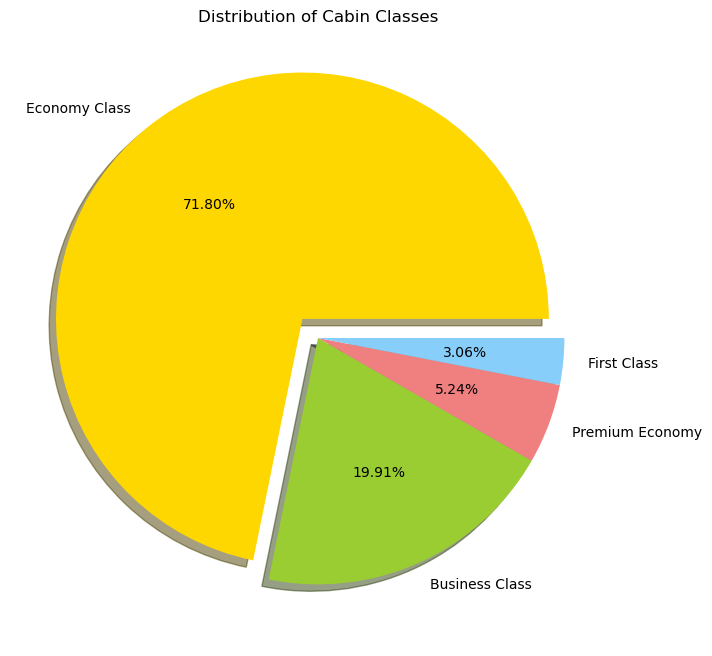

In [736]:
cabin_counts = df_final['cabin'].value_counts()

plt.figure(figsize=(10, 8))
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'orange']  
explode = (0.1, 0, 0, 0) 

plt.pie(cabin_counts, labels=cabin_counts.index, autopct='%.2f%%', colors=colors, explode=explode, shadow=True)
plt.title('Distribution of Cabin Classes')
plt.show()

Inference:
        
        Overall, the data suggests that Economy Class is the most commonly chosen cabin class, while First Class is the least chosen. 


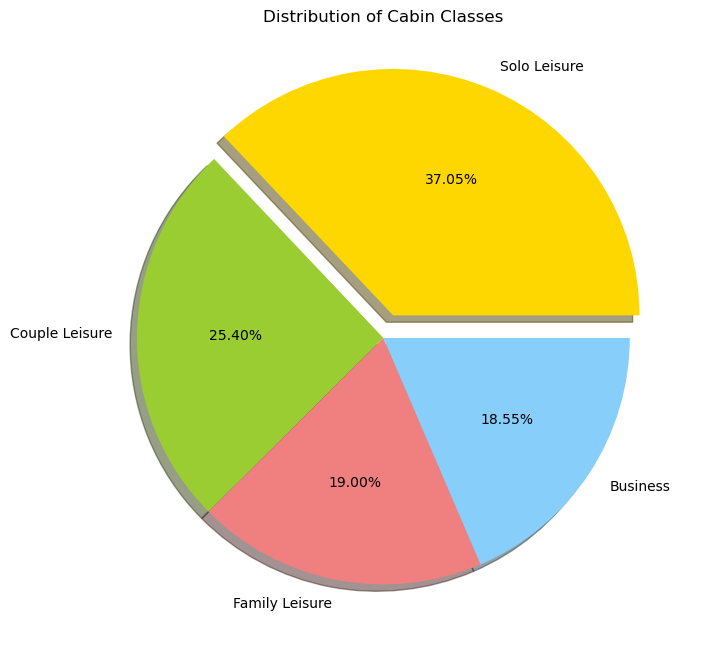

In [737]:
cabin_counts = df_final['traveller_type'].value_counts()

plt.figure(figsize=(10, 8))
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'orange']  
explode = (0.1, 0, 0, 0) 

plt.pie(cabin_counts, labels=cabin_counts.index, autopct='%.2f%%', colors=colors, explode=explode, shadow=True)
plt.title('Distribution of Cabin Classes')
plt.show()



Inference:
        
        Considering the types of travelers, majority of them belong to solo leisure type while the least number of travelers belong to business type

In [738]:
df_num = df_final.select_dtypes(include=np.number)
df_num

,overall_review,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money
0,7.0,4.0,5.0,4.0,4.0,2.0,4.0
1,2.0,4.0,1.0,1.0,1.0,1.0,1.0
2,3.0,1.0,4.0,1.0,3.0,1.0,2.0
3,10.0,4.0,5.0,5.0,5.0,5.0,5.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
22814,1.0,1.0,1.0,1.0,1.0,1.0,1.0
22815,1.0,1.0,2.0,1.0,1.0,1.0,1.0
22816,10.0,5.0,5.0,5.0,4.0,4.0,4.0
22817,2.0,1.0,1.0,1.0,1.0,1.0,1.0


In [739]:
colors = sns.color_palette('husl', len(df_num.columns)+1)
colors

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8087954113106306, 0.5634700050056693, 0.19502642696727285),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.19783576093349015, 0.6955516966063037, 0.3995301037444499),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.22335772267769388, 0.6565792317435265, 0.8171355503265633),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.9603888539940703, 0.3814317878772117, 0.8683117650835491)]

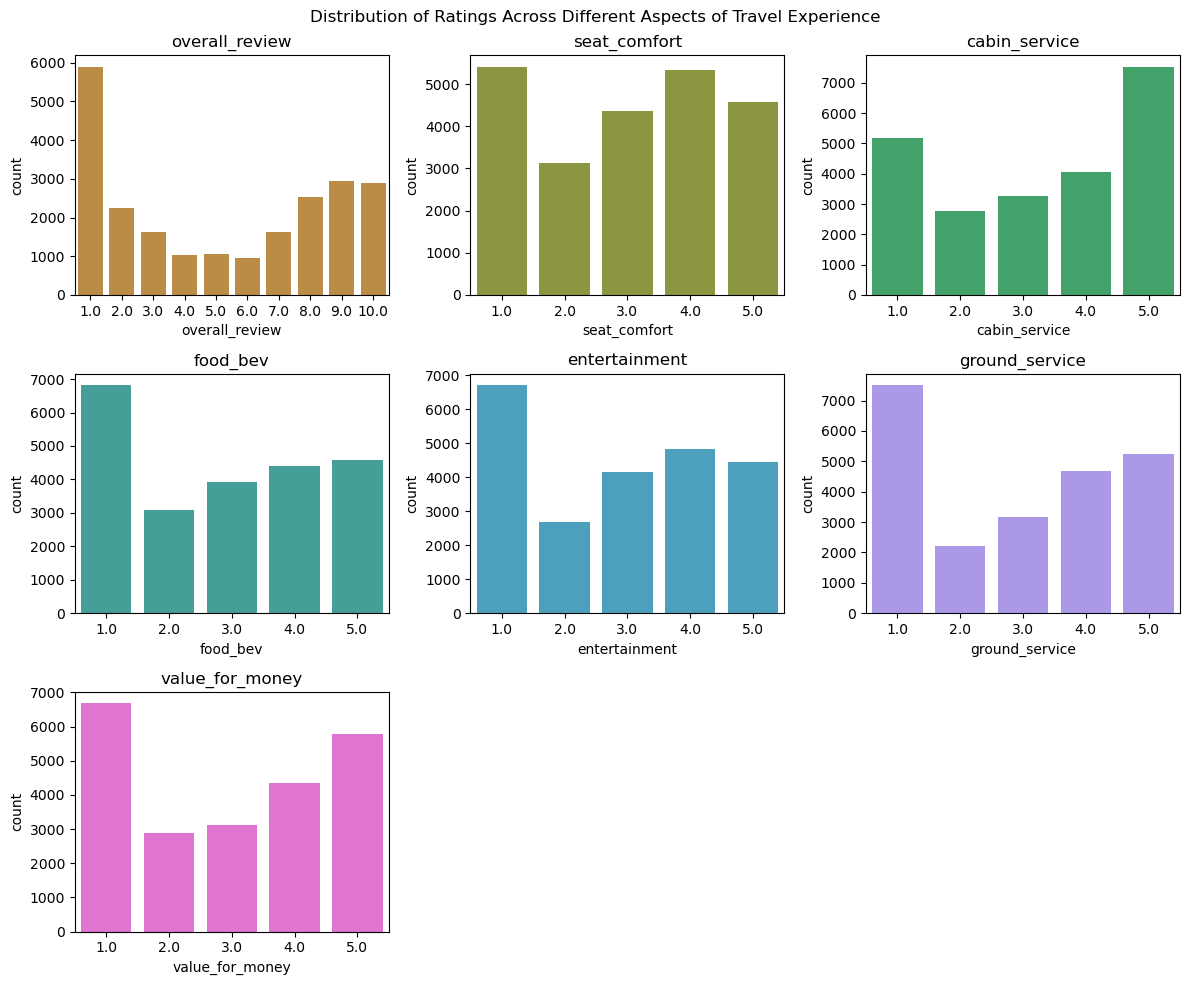

In [740]:
j=1
plt.figure(figsize=(12,10))
for i in df_num:
    plt.subplot(3,3,j)
    sns.countplot(x=df_final[i],color=colors[j])
    plt.title(i)
    j+=1
plt.suptitle('Distribution of Ratings Across Different Aspects of Travel Experience')

plt.tight_layout()
plt.show()

Inference:

    1. Compare to all the different rating columns cabin service has highest count of 5 star ratings.
    2. Airlines need to focus mainly on Food_bev, entertainment, ground service and vale for money columns because these 
    have more 1 ratings.

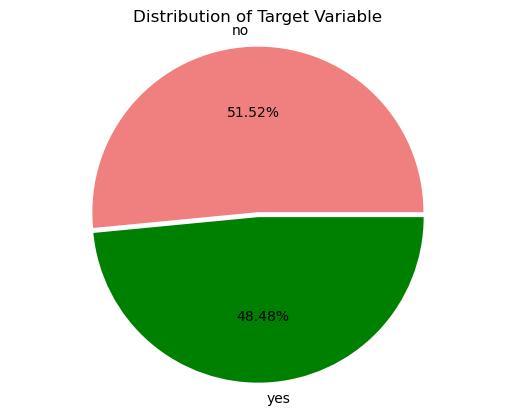

In [741]:
colors = ['lightcoral','green']
explode = (0.03, 0)
plt.pie(df_final['recommended'].value_counts(),labels=df['recommended'].value_counts().index,autopct='%.2f%%',colors=colors,explode=explode)
plt.title('Distribution of Target Variable')
plt.axis('equal')
plt.show()

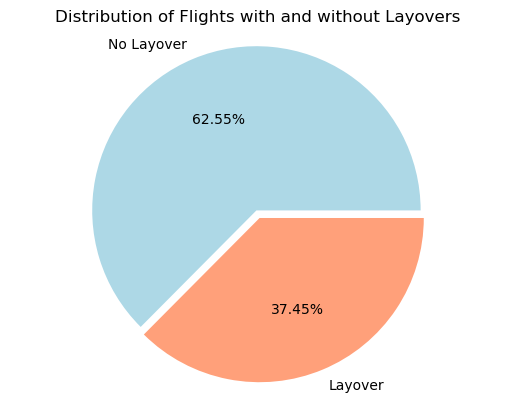

In [742]:
explode = (0.05, 0)
colors = ['lightblue', 'lightsalmon']
plt.pie(df_final['has_layover'].value_counts(),labels=['No Layover','Layover'],autopct='%.2f%%',colors=colors,explode=explode)
plt.title('Distribution of Flights with and without Layovers')
plt.axis('equal')
plt.show()

# Bi Variate Analysis

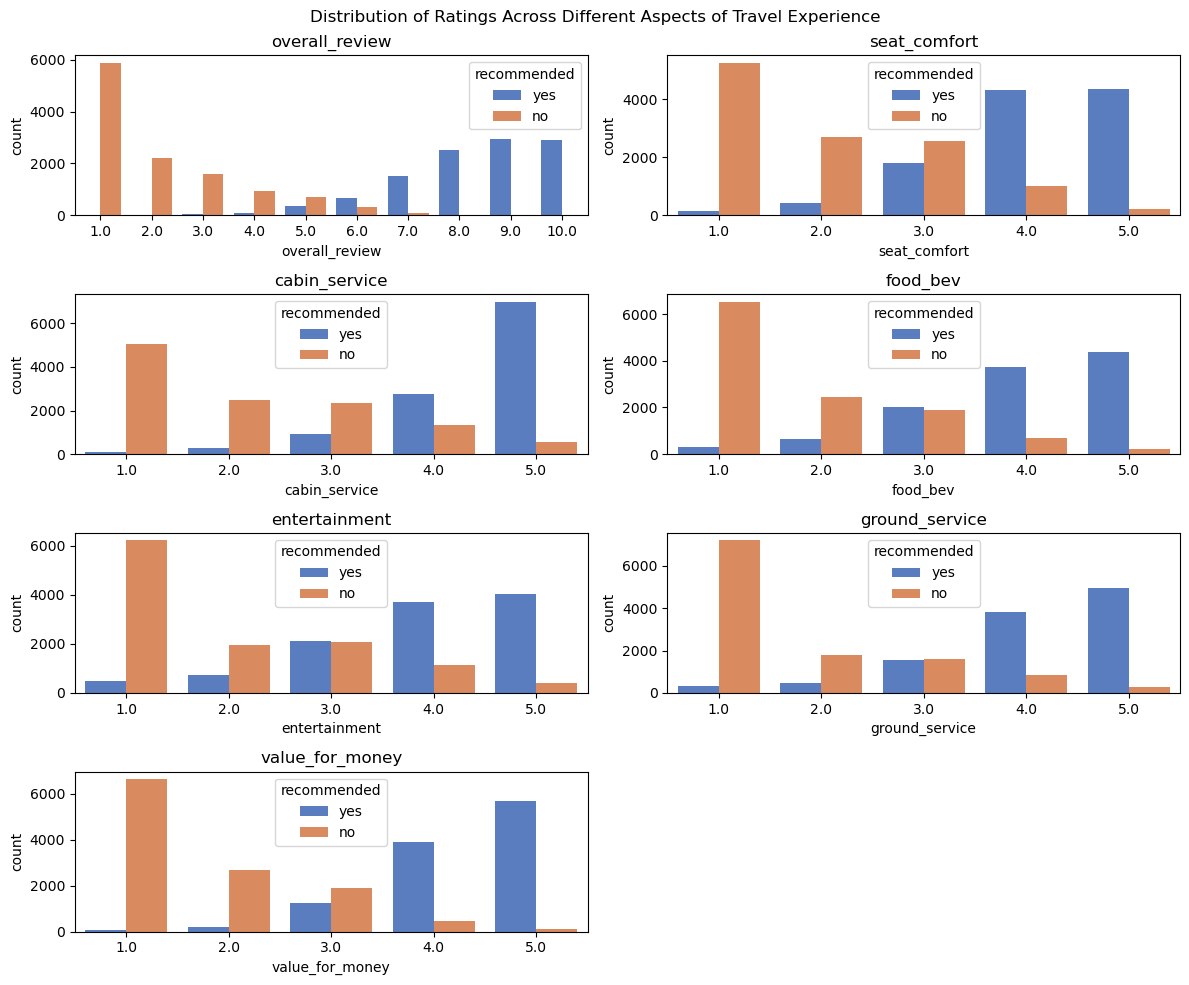

In [743]:
j=1
plt.figure(figsize=(12,10))
for i in df_num:
    plt.subplot(4,2,j)
    sns.countplot(x=df_final[i],hue=df_final['recommended'],palette='muted')
    plt.title(i)
    j+=1
plt.suptitle('Distribution of Ratings Across Different Aspects of Travel Experience')

plt.tight_layout()
plt.show()


Inference:
        
        1. We can easily conclude that there is a high chance of recommending if it was 4 or 5 rating.
        2. Viceversa, If rating is less than 3 then there is a high chance that he won't recommended. 

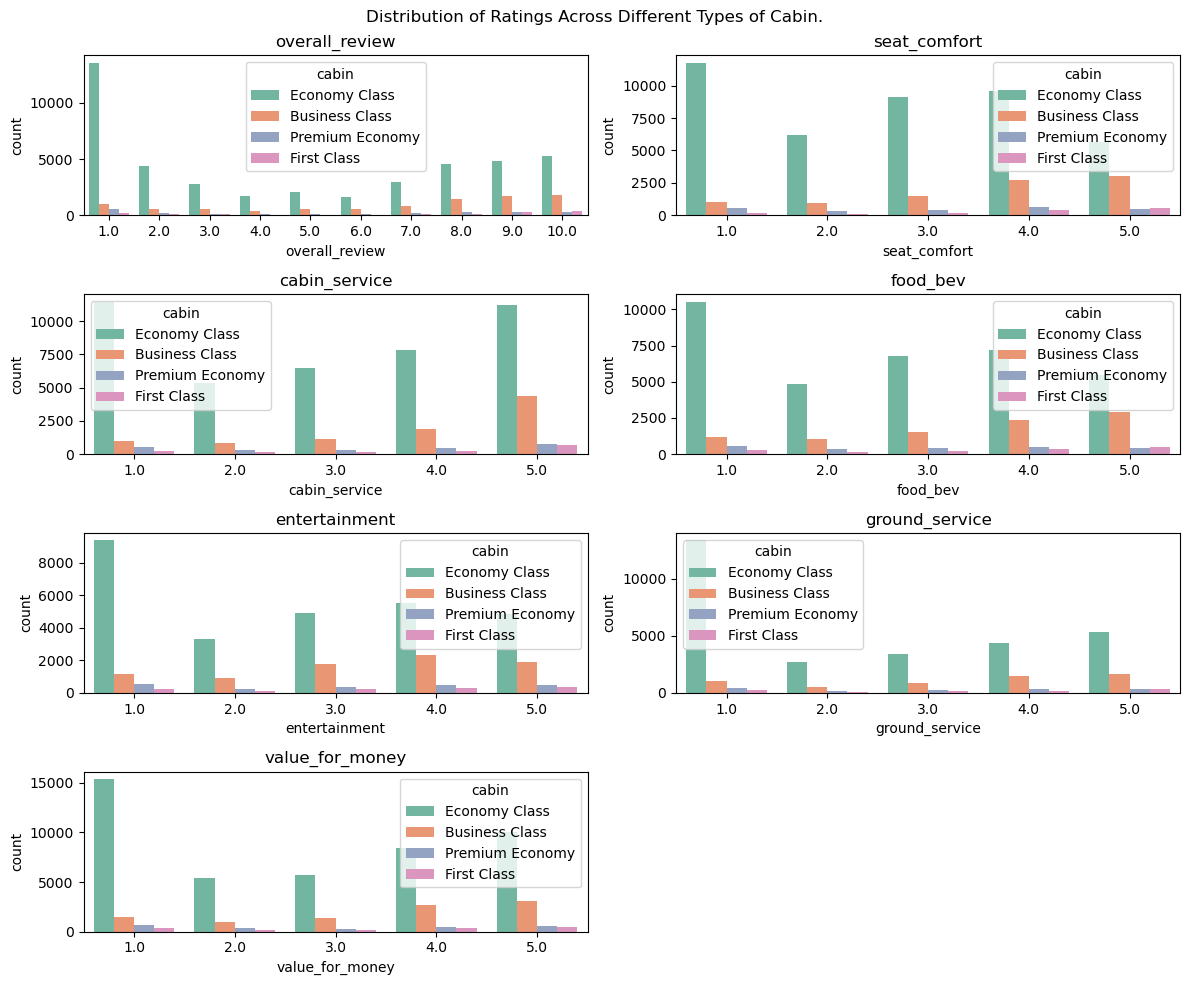

In [744]:
j=1
plt.figure(figsize=(12,10))
for i in df_num:
    plt.subplot(4,2,j)
    sns.countplot(x=df[i],hue=df['cabin'],palette='Set2')
    plt.title(i)
    j+=1
plt.suptitle('Distribution of Ratings Across Different Types of Cabin.')

plt.tight_layout()
plt.show()

In [745]:
top_airlines = df_final['airline'].value_counts().head(5).index
df_top5 = df_final[df_final['airline'].isin(top_airlines)]


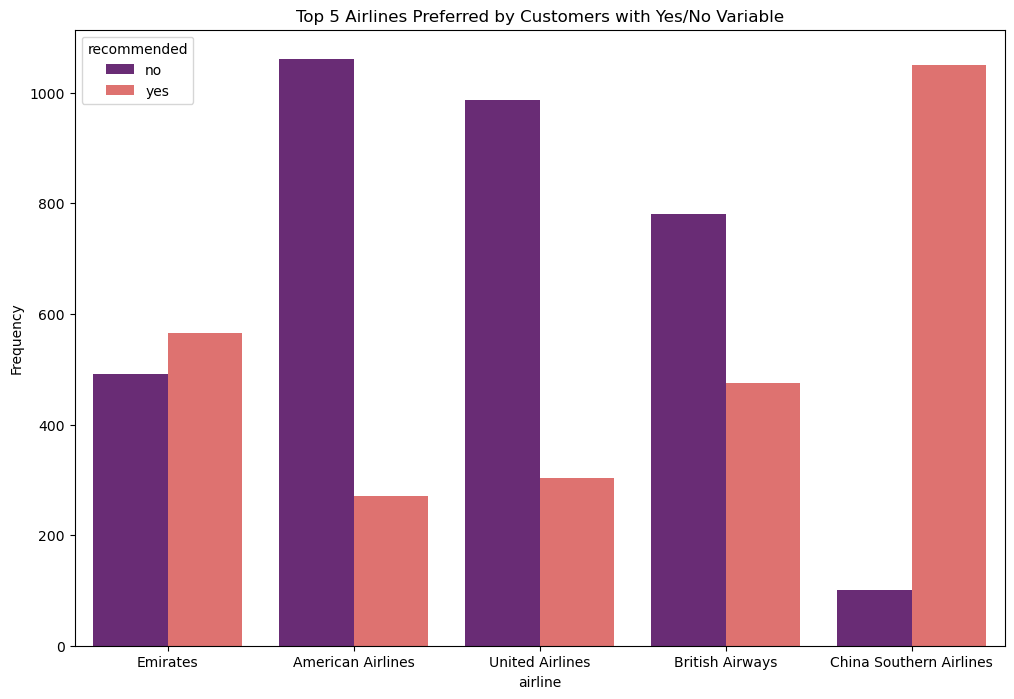

In [746]:

plt.figure(figsize=(12,8))

sns.countplot(data=df_top5, x='airline', hue='recommended',palette='magma')
plt.ylabel('Frequency')
plt.title('Top 5 Airlines Preferred by Customers with Yes/No Variable')
plt.show()

Inference:

    1. Majority of the customers have recommened Cathay Pacific Airways among the top 5 airlines.
    2. In British Airline there were almost equal no. of yes and no's. So there is a 50% chance that person will 
    recommended this.


## Correlation plot

In [747]:
df_final.dtypes
#Converting all the date columns to numeric

airline                      object
overall_review              float64
review_text                  object
traveller_type               object
cabin                        object
route                        object
seat_comfort                float64
cabin_service               float64
food_bev                    float64
entertainment               float64
ground_service              float64
value_for_money             float64
recommended                  object
has_layover                  object
Review_Date                  object
Review_Month                 object
Review_Year                  object
date_flown_month             object
date_flown_year              object
pos_neu_neg_review_score     object
dtype: object

In [748]:
df_final[['Review_Date','Review_Year','date_flown_year']] = df_final[['Review_Date','Review_Year','date_flown_year']].astype(int)

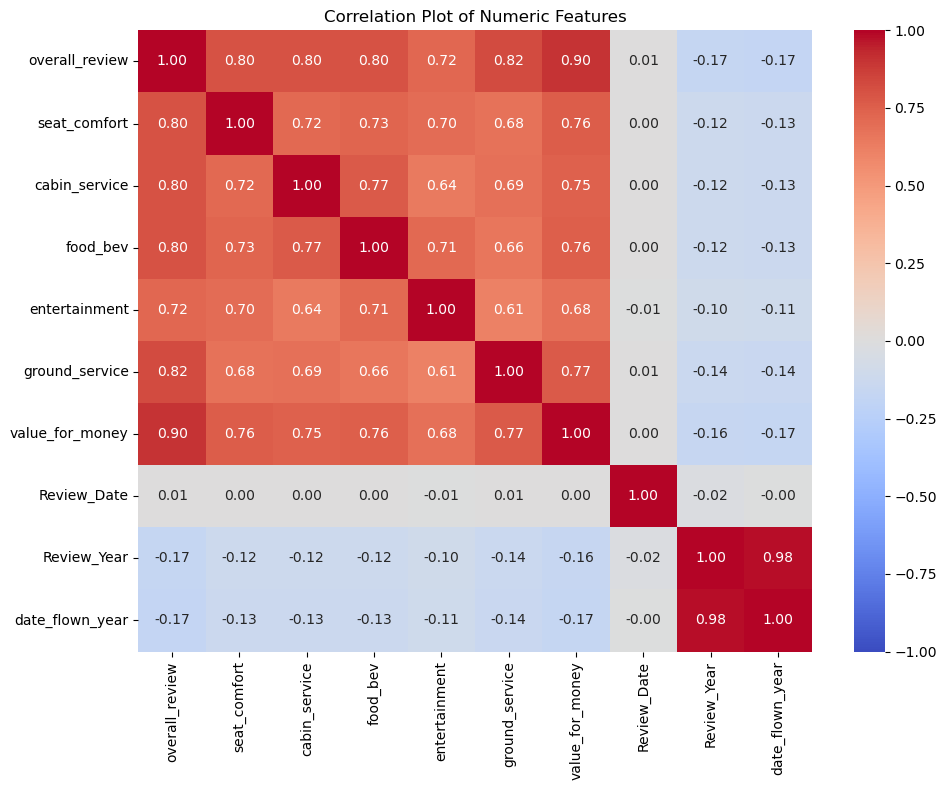

In [749]:
corr_matrix = df_final.select_dtypes(include=np.number).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Plot of Numeric Features')
plt.tight_layout()
plt.show()

Few points of notice:

    1 . A positive correlation between the different types of review scores and subscores.

In [750]:
df_1=df_final[df_final['recommended']=='yes']
df_2=df_final[df_final['recommended']=='no']

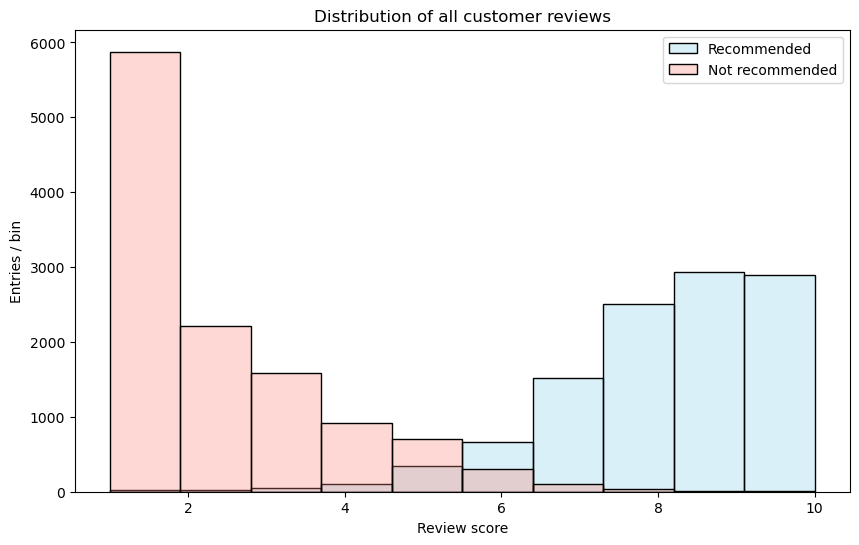

In [751]:
plt.figure(figsize=(10, 6))
sns.histplot(df_1['overall_review'], bins=10, color='skyblue', label='Recommended', alpha=0.3)
sns.histplot(df_2['overall_review'], bins=10, color='salmon', label='Not recommended', alpha=0.3)
plt.title('Distribution of all customer reviews')
plt.xlabel('Review score')
plt.ylabel('Entries / bin')
plt.legend()
plt.show()

Positive customer reviews tend to be shorter than negative customer reviews (see mean of the distribution of the number of characters in the customer review). The same trend is observed if using the number of words instead of the number of characters.

In [752]:
review_text = df_final['review_text']

In [753]:
del df_final['review_text']

# Encoding


In [754]:
df_final.columns

Index(['airline', 'overall_review', 'traveller_type', 'cabin', 'route',
       'seat_comfort', 'cabin_service', 'food_bev', 'entertainment',
       'ground_service', 'value_for_money', 'recommended', 'has_layover',
       'Review_Date', 'Review_Month', 'Review_Year', 'date_flown_month',
       'date_flown_year', 'pos_neu_neg_review_score'],
      dtype='object')

In [755]:
df_features = df_final[['traveller_type', 'cabin','seat_comfort', 'cabin_service', 'food_bev', 'entertainment',
       'ground_service', 'value_for_money','pos_neu_neg_review_score','has_layover']]

df_target = df_final['recommended']

**Encoding cabin column**

In [756]:
df_features['cabin'].value_counts()

cabin
Economy Class      16383
Business Class      4543
Premium Economy     1195
First Class          698
Name: count, dtype: int64

In [757]:
cabin_order = ['Economy Class', 'Premium Economy', 'Business Class', 'First Class']
encoder = OrdinalEncoder(categories=[cabin_order])

df_features['cabin_enc'] = encoder.fit_transform(df_features[['cabin']])

In [758]:
df_features['cabin_enc'].value_counts()

cabin_enc
0.0    16383
2.0     4543
1.0     1195
3.0      698
Name: count, dtype: int64

In [759]:
del df_features['cabin']

**Encoding pos_neu_neg_review_score column**

In [760]:
df_features['pos_neu_neg_review_score'].value_counts()

pos_neu_neg_review_score
neg    10793
pos    10013
neu     2013
Name: count, dtype: int64

In [761]:
review_score_order = ['neg', 'neu', 'pos']
encoder = OrdinalEncoder(categories=[review_score_order])

df_features['pos_neu_neg_review_score_enc'] = encoder.fit_transform(df_features[['pos_neu_neg_review_score']])

In [762]:
df_features['pos_neu_neg_review_score_enc'].value_counts()

pos_neu_neg_review_score_enc
0.0    10793
2.0    10013
1.0     2013
Name: count, dtype: int64

In [763]:
del df_features['pos_neu_neg_review_score']

**Encoding has_layover column**

In [764]:
df_features['has_layover'] = df_features['has_layover'].replace({True:1,False:0})

**Encoding traveller_type column**

In [765]:
df_features = pd.get_dummies(df_features,drop_first=True,dtype=int)

In [766]:
df_features.head()

,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,has_layover,cabin_enc,pos_neu_neg_review_score_enc,traveller_type_Couple Leisure,traveller_type_Family Leisure,traveller_type_Solo Leisure
0,4.0,5.0,4.0,4.0,2.0,4.0,1,0.0,2.0,0,0,0
1,4.0,1.0,1.0,1.0,1.0,1.0,0,0.0,0.0,0,1,0
2,1.0,4.0,1.0,3.0,1.0,2.0,1,0.0,0.0,0,0,0
3,4.0,5.0,5.0,5.0,5.0,5.0,0,0.0,2.0,0,0,1
4,1.0,1.0,1.0,1.0,1.0,1.0,1,0.0,0.0,0,0,1


**Encoding Target**

In [767]:
df_target = df_target.replace({'yes':1,'no':0})

In [768]:
df_features.shape

(22819, 12)

# NLP(Natural Language Processing)

In [769]:
review_text[0]

'London to Izmir via Istanbul. First time Iâ€™d flown TK. I found them very good in the air, cabin crew, planes, food, all very nice. Not so great on the ground, ground staff, call centre, computer systems. My flight from LHR was delayed so I missed the connection in Istanbul. Most ground staff donâ€™t speak English, and I was given contradictory instructions from those that could speak a little English. I eventually got on a flight to Izmir three hours later, but it wasnâ€™t an easy process, made worse by the vast distances one has to walk between gates in the cavernous new airport. Also, Iâ€™d phoned a TK call centre (based in Ukraine) to pay an extra Â£40 or so each way for extra leg room seats. However, as the departure times kept changing, my seats kept changing, and for the return leg to London from Istanbul I was not given an extra leg room seat. Luckily there was a spare exit row seat and the cabin crew sorted me out. Overall, I think their cabin crew and planes are very good, 

## Text Preprocessing 

* Lowercasing
* Stop-word removal
* Removing punctuation and special characters
* Removal of URLs
* Removal of HTML tags
* lemmatization
* Tokenization

In [770]:
df_nlp = pd.DataFrame(review_text)

In [771]:
df_nlp.head()

,review_text
0,London to Izmir via Istanbul. First time Iâ€™d...
1,Istanbul to Bucharest. We make our check in in...
2,Rome to Prishtina via Istanbul. I flew with th...
3,Flew on Turkish Airlines IAD-IST-KHI and retur...
4,Mumbai to Dublin via Istanbul. Never book Turk...


### Lowercasing

In [772]:
def convert_to_lower(row):
    return row.str.lower()
df_nlp = df_nlp.apply(convert_to_lower)

In [773]:
df_nlp['review_text'][0]

'london to izmir via istanbul. first time iâ€™d flown tk. i found them very good in the air, cabin crew, planes, food, all very nice. not so great on the ground, ground staff, call centre, computer systems. my flight from lhr was delayed so i missed the connection in istanbul. most ground staff donâ€™t speak english, and i was given contradictory instructions from those that could speak a little english. i eventually got on a flight to izmir three hours later, but it wasnâ€™t an easy process, made worse by the vast distances one has to walk between gates in the cavernous new airport. also, iâ€™d phoned a tk call centre (based in ukraine) to pay an extra â£40 or so each way for extra leg room seats. however, as the departure times kept changing, my seats kept changing, and for the return leg to london from istanbul i was not given an extra leg room seat. luckily there was a spare exit row seat and the cabin crew sorted me out. overall, i think their cabin crew and planes are very good, 

### Handling Stop-words

In [774]:
df_nlp['review_text'][0].split('.')[0]
#Removing route part in text.

'london to izmir via istanbul'

In [775]:
route_stopwords = list(set(' '.join(df_final['route'].str.lower().unique()).split(' ')))

# Words appearing in the official name of the airlines. These words should be removed from the review text.
airlines_identifier = ['airlines',
                       'air lines',
                       'airline',
                       'air line',
                       'airways',
                       'air']

# Other stop words.
additional_stopwords = ['one','get','also','however','even','make']


In [776]:
stop_words = stopwords.words('english')
len(stop_words)

179

In [777]:
Final_stop_words = route_stopwords + airlines_identifier + additional_stopwords + stop_words


In [778]:
df_nlp['review_text'] = df_nlp['review_text'].apply(lambda x:' '.join(x for x in x.split() if x not in Final_stop_words))


### Removing punctuation and special characters

In [779]:
def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [780]:
df_nlp['review_text'] = df_nlp['review_text'].apply(preprocess_text)

### Lemmatizing the text using pos_tag.


In [781]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [782]:
# Example of POS tagging.
pos_tag(word_tokenize('Example pos tag is working'))

[('Example', 'NNP'),
 ('pos', 'NN'),
 ('tag', 'NN'),
 ('is', 'VBZ'),
 ('working', 'VBG')]

In [783]:
stemming = WordNetLemmatizer()

In [784]:
df_nlp['review_text'] = df_nlp['review_text'].apply(lambda x: ' '.join(stemming.lemmatize(i,pos=get_wordnet_pos(i)) for i in x.split()))

In [785]:
positive_words = ' '.join(df_nlp[df_final['pos_neu_neg_review_score']=='pos']['review_text'])
neutral_words =  ' '.join(df_nlp[df_final['pos_neu_neg_review_score']=='neu']['review_text'])
negative_words = ' '.join(df_nlp[df_final['pos_neu_neg_review_score']=='neg']['review_text'])

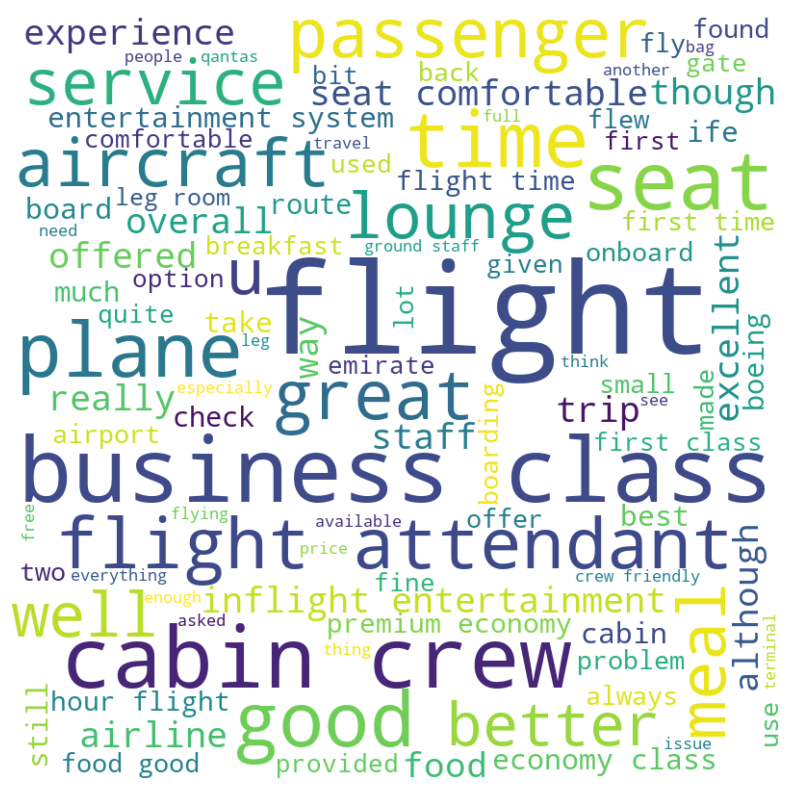

In [786]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',  # Change background color
                      width=800,                 # Change width of the WordCloud image
                      height=800,                # Change height of the WordCloud image
                      max_words=100,             # Maximum number of words to display
                      colormap='viridis',        # Color map for the WordCloud
                      contour_width=1,           # Width of the contour lines
                      contour_color='steelblue'  # Color of the contour lines
                     ).generate(positive_words)

# Display the WordCloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**well,good,friendly,quality,cabin crew, great, time,excellent these are the few important keywords for the customer's who gave reviews greater than 6.**

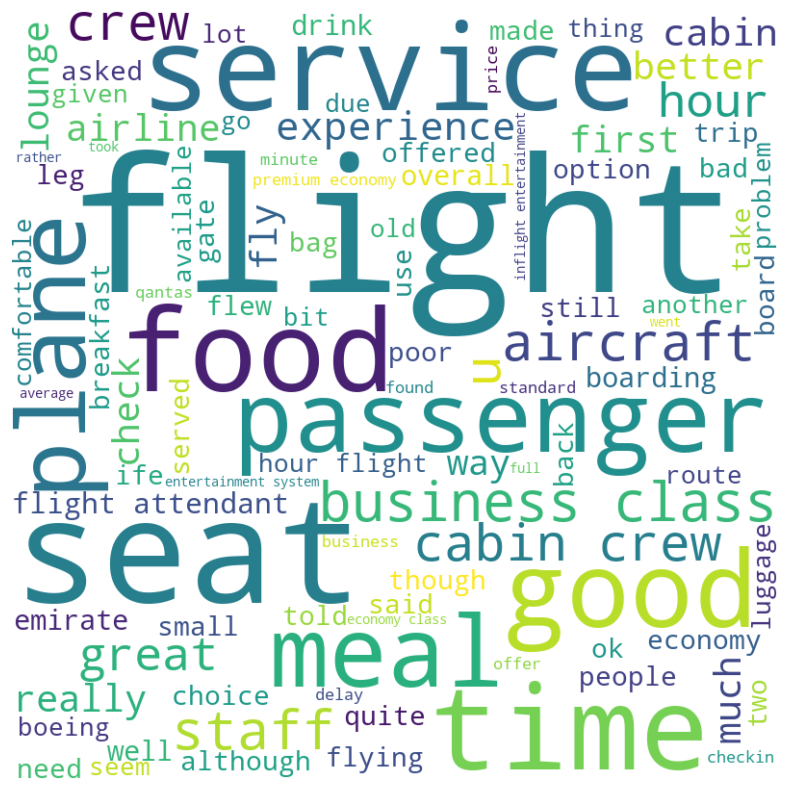

In [787]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',  # Change background color
                      width=800,                 # Change width of the WordCloud image
                      height=800,                # Change height of the WordCloud image
                      max_words=100,             # Maximum number of words to display
                      colormap='viridis',        # Color map for the WordCloud
                      contour_width=1,           # Width of the contour lines
                      contour_color='steelblue'  # Color of the contour lines
                     ).generate(neutral_words)

# Display the WordCloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**time,seat,good,service,food,hour,class,staff,boarding,crew,lounge,passenger,economy,meal,gate,aircraft,experience,ground,
plane,entertainment,cabin these are the few important keywords for the customer's who gave reviews greater than 4.** 

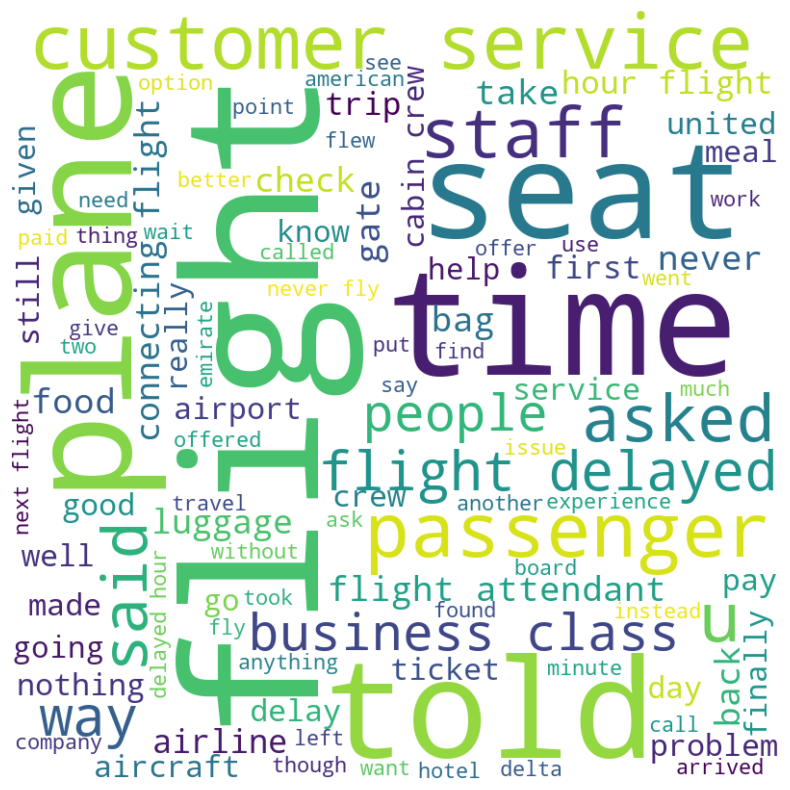

In [788]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',  # Change background color
                      width=800,                 # Change width of the WordCloud image
                      height=800,                # Change height of the WordCloud image
                      max_words=100,             # Maximum number of words to display
                      colormap='viridis',        # Color map for the WordCloud
                      contour_width=1,           # Width of the contour lines
                      contour_color='steelblue'  # Color of the contour lines
                     ).generate(negative_words)

# Display the WordCloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**flight,hour,seat,time,service,staff,ticket,plane,told,customer,luggage,would,food,business,gate,back,experience,boarding these are the few important keywords for the customer's who gave reviews less than 3.**

### Vectorizing text
* Vectorizing text refers to the process of converting text data into numerical vectors that machine learning models can understand. This is a crucial step in natural language processing (NLP) tasks. 

In [811]:
print('No. of rows in my features',df_features.shape[0])

No. of rows in my features 22819


In [810]:
print('No. of rows for my text column',df_nlp.shape[0])

No. of rows for my text column 22819


### Concating both of them

In [808]:
df_final_1 = pd.concat([df_features,df_nlp],axis=1)

In [814]:
print('No. of rows and columns for my dataframe',df_final_1.shape)

No. of rows and columns for my dataframe (22819, 13)


In [813]:
from sklearn.model_selection import train_test_split

In [816]:
X = df_final_1
y = df_target

In [817]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,random_state=1,train_size=0.7,stratify=y)

In [818]:
print(xtrain.shape)
print(xtest.shape)

(15973, 13)
(6846, 13)


### Term Frequency-Inverse Document Frequency (TF-IDF)
TF-IDF considers the importance of words in a document relative to their frequency in the entire corpus. It calculates a weight for each word that increases with the number of times it appears in the document (term frequency) but decreases with the frequency of the word in the corpus (inverse document frequency). This helps in giving more weight to words that are important in a document but less common in the corpus.

In [789]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [790]:
TfidfVector = TfidfVectorizer(min_df=10)

**Summary:**

- `vector.fit(sampleTrain)` **learn the vocabulary** from training data
- `vector.transform(sampleTrain)` use the **trained vocabulary** to build DTM from the train data
- `vector.transform(sampleTest)` use the **trained vocabulary** to build a DTM from the test data and **ignore vocabulary** it hasn't seen before

In [822]:
TfidfVector.fit(xtrain['review_text'])

TfidfVectorizer(min_df=10)

In [824]:
# transform the words into Document Term Matrix -DTM
DTM_train = TfidfVector.transform(xtrain['review_text'])
DTM_train
#sparse matrix which means it contains only non-null values

<15973x5236 sparse matrix of type '<class 'numpy.float64'>'
	with 867955 stored elements in Compressed Sparse Row format>

In [825]:
# transform the words into Document Term Matrix -DTM
DTM_test = TfidfVector.transform(xtest['review_text'])
DTM_test
#sparse matrix which means it contains only non-null values

<6846x5236 sparse matrix of type '<class 'numpy.float64'>'
	with 372324 stored elements in Compressed Sparse Row format>

In [831]:
DTM_test.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [844]:
df_train_vector = pd.DataFrame(DTM_train.toarray(),index=xtrain.index,columns=TfidfVector.get_feature_names_out())
df_train_vector.head()

,aa,ab,ababa,abandoned,ability,able,aboard,about,above,abreast,...,yourself,yr,yummy,yvr,yyz,zealand,zero,zone,zoo,zurich
13441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [843]:
df_test_vector = pd.DataFrame(DTM_test.toarray(),index=xtest.index,columns=TfidfVector.get_feature_names_out())
df_test_vector.head()

,aa,ab,ababa,abandoned,ability,able,aboard,about,above,abreast,...,yourself,yr,yummy,yvr,yyz,zealand,zero,zone,zoo,zurich
9909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [845]:
xtrain_vector = pd.concat([xtrain,df_train_vector],axis=1)
xtest_vector = pd.concat([xtest,df_test_vector],axis=1)


In [848]:
print('No of rows and columns',xtrain_vector.shape)
print('No of rows and columns',xtest_vector.shape)

No of rows and columns (15973, 5249)
No of rows and columns (6846, 5249)


In [857]:
#Dropping review text column because it is already converted into vector.
del xtrain_vector['review_text']
del xtest_vector['review_text']

# Building Model

In [852]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve,accuracy_score,cohen_kappa_score

In [853]:
def model_validation(model,X_train,Y_train,X_test,Y_test):
    global m
    m=model
    m.fit(X_train,Y_train)
    ypred=m.predict(X_test)            #hard prediction(0,1)
    prob=m.predict_proba(X_test)[:,-1] #soft prediction (probability of 1)
    
    print('Accuracy:',accuracy_score(Y_test,ypred))
    print('Confusion Matric:\n',confusion_matrix(Y_test,ypred))
    print('Report:\n', classification_report(Y_test,ypred))
    print('Cohen kappa score:',cohen_kappa_score(Y_test,ypred))
    
    fpr,tpr,thr=roc_curve(Y_test,prob)
    plt.plot(fpr,tpr,color='blue')
    plt.plot([0,1],[0,1],color='red')
    plt.title(f'AUC SCORE{roc_auc_score(Y_test,prob)}')

Accuracy: 0.951066316096991
Confusion Matric:
 [[3343  184]
 [ 151 3168]]
Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      3527
           1       0.95      0.95      0.95      3319

    accuracy                           0.95      6846
   macro avg       0.95      0.95      0.95      6846
weighted avg       0.95      0.95      0.95      6846

Cohen kappa score: 0.9020709173584456


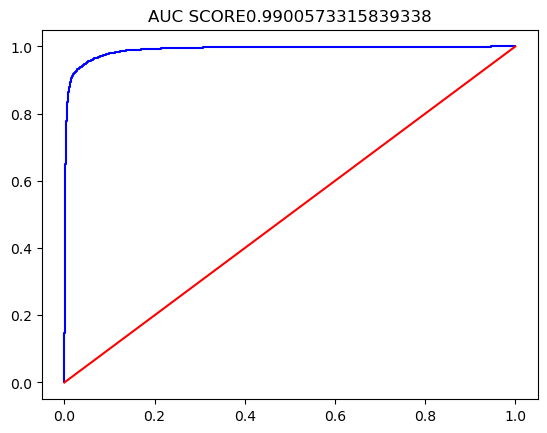

In [858]:
base_model = LogisticRegression()
model_validation(base_model,xtrain_vector,ytrain,xtest_vector,ytest)

# Tuning the base model.

param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'max_iter': [100, 200, 300]  # Maximum number of iterations taken for the solvers to converge
}

gscv = GridSearchCV(estimator=LogisticRegression(),
            param_grid=param_grid,
            scoring='roc_auc',
            cv=5,
             verbose=1)

gscv.fit(xtrain,ytrain)


print('best parameters',gscv.best_params_)

print('best_score',gscv.best_score_)


lr_tuned = LogisticRegression(**gscv.best_params_)
model_validation(lr_tuned,xtrain,ytrain,xtest,ytest)


# Building model on Decision Tree Classifier


In [860]:
Parameters = { 'max_depth' : [3,5,7,9,11,13,15],
               'min_samples_split'  : [10,20,30,40,50] 
    
    
}

gscv = GridSearchCV(estimator=DecisionTreeClassifier(),
            param_grid=Parameters,
            scoring='roc_auc',
            cv=10,
             verbose=1)

gscv.fit(xtrain_vector,ytrain)

print('best parameters',gscv.best_params_)

print('best_score',gscv.best_score_)

Accuracy: 0.9325153374233128
Confusion Matric:
 [[3282  245]
 [ 217 3102]]
Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93      3527
           1       0.93      0.93      0.93      3319

    accuracy                           0.93      6846
   macro avg       0.93      0.93      0.93      6846
weighted avg       0.93      0.93      0.93      6846

Cohen kappa score: 0.8649395658477115


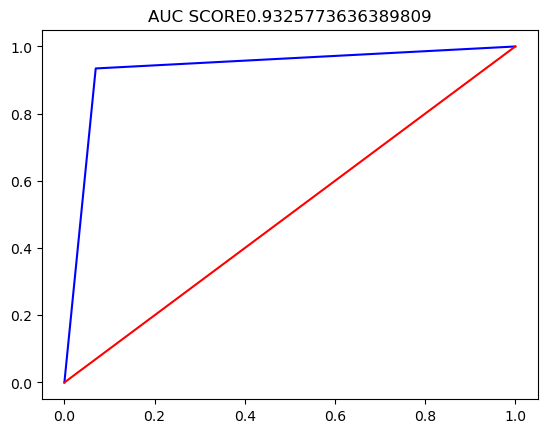

In [864]:


dtc = DecisionTreeClassifier()
model_validation(dtc,xtrain_vector,ytrain,xtest_vector,ytest)
